# Importation

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 15 10:08:37 2024

@author: Ana
"""

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import copy
import pandas as pd
from skimage import io, img_as_float, exposure
from scipy.interpolate import UnivariateSpline, CubicSpline, RectBivariateSpline
from scipy.ndimage import uniform_filter
from mpl_toolkits.mplot3d import Axes3D
import time

# General system functions
import glob
import os
import shutil
import sys




# Define functions

In [5]:
global length 

def draw_line(event, x, y, flags, param):
    global line_coordinates 
    
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(line_coordinates) < 2:
            line_coordinates.append((x, y))

            if len(line_coordinates) == 2:
                cv2.line(param, line_coordinates[0], line_coordinates[1], (255,255,51), 2)
                cv2.imshow("Draw Line", param)

def extract_line_coord(image):
    # Create a window for image display
    cv2.namedWindow("Draw Line", cv2.WINDOW_NORMAL)
    # Set the callback function for mouse events
    cv2.setMouseCallback("Draw Line", draw_line, param=image)
    # Display the image
    cv2.imshow("Draw Line", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def read_tiff_images_cv2(TopStack, line_coordinates):

    # Initialize an empty list to store all images
    all_images = []
    line =copy.deepcopy(line_coordinates)
    # Read the line coordinates

    reslice_jet = []
    reslice_splash = []
    # Iterate through images
    for file in TopStack[8:25]:
        # Check if the file is a TIFF image
        # if file.lower().endswith(".tiff") or file.lower().endswith(".tif"):
        # file_path = os.path.join(folder_path, file)

        # Read the TIFF image using cv2
        try:
            # image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            
            Gaussian = cv2.GaussianBlur(file, (3, 3), 0) 

            # cv2.imshow('Gaussian Blurring', Gaussian) 
            image = Gaussian
            # plt.figure()
            # plt.imshow(image)
            
            (x1, y1), (x2, y2) = line
            angle_jet = math.atan2(line[1][1] - line[0][1], line[1][0] - line[0][0])
            x2 = x1 + int(length * math.cos(angle_jet))
            y2 = y1 + int(length * math.sin(angle_jet))
         
            # Convert the image data to a list
            image_data = image.tolist()

            # Append the list of pixel values to the main list
            all_images.append(image_data)

            # Extract pixels along the drawn line using Bresenham's algorithm
            line_pixels_jet = []
            dx = abs(x2 - x1)
            dy = abs(y2 - y1)
            sx = 1 if x1 < x2 else -1
            sy = 1 if y1 < y2 else -1
            err = dx - dy

            while True:
                line_pixels_jet.append(image[y1, x1].tolist())

                if x1 == x2 and y1 == y2:
                    break

                e2 = 2 * err
                if e2 > -dy:
                    err = err - dy
                    x1 = x1 + sx
                if e2 < dx:
                    err = err + dx
                    y1 = y1 + sy

            reslice_jet.append(line_pixels_jet)
            
            (x1, y1) = line[0]
            angle_splash = angle_jet-np.pi/2
            x3 = x1 + int(length * math.cos(angle_splash))
            y3 = y1 + int(length * math.sin(angle_splash))
            
            # Extract pixels along the drawn line using Bresenham's algorithm
            line_pixels_splash = []
            dx = abs(x3 - x1)
            dy = abs(y3 - y1)
            sx = 1 if x1 < x3 else -1
            sy = 1 if y1 < y3 else -1
            err = dx - dy

            while True:
                line_pixels_splash.append(image[y1, x1].tolist())

                if x1 == x3 and y1 == y3:
                    break

                e2 = 2 * err
                if e2 > -dy:
                    err = err - dy
                    x1 = x1 + sx
                if e2 < dx:
                    err = err + dx
                    y1 = y1 + sy

            reslice_splash.append(line_pixels_splash)
        
        except Exception as e:
            print(f"Error processing {file}: {e}")
    # Transpose the reslice images to swap rows and columns
    # Rotate the reslice images by 90 degrees (clockwise)
    # Rotate the reslice images by 90 degrees (counterclockwise)
    # reslice_jet_rotated = list(map(list, zip(*reslice_jet)))[::-1]
    # reslice_splash_rotated = list(map(list, zip(*reslice_splash)))[::-1]
    
    reslice = [reslice_jet, reslice_splash]
    
    return all_images, reslice

def onMouse(event, x, y, flags, param):
   global posList
   if event == cv2.EVENT_LBUTTONDOWN:
        posList.append((x, y))
        
def average_stack(TopStack, count):

    # Initialize an empty list to store all images
    
    all_images = TopStack[0]
    # Iterate through images
    
    for file in TopStack[1:count]:
        # Check if the file is a TIFF image
        # if file.lower().endswith(".tiff") or file.lower().endswith(".tif"):
        # file_path = os.path.join(folder_path, file)

        # Read the TIFF image using cv2
        all_images = all_images + file 
        all_images = all_images/(count+1)
        # print(np.max(file))
    return all_images

def extract_spline(image):
    global selected_points, display_image
    display_image = copy.deepcopy(image)
    # List to store the selected points
    selected_points = []

    # Create a window and bind the mouse callback function to it
    cv2.namedWindow('Select Points', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('Select Points', mouse_callback)

    # Display the original image for point selection
    cv2.imshow('Select Points', display_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Convert selected points to numpy array
    selected_points = np.array(selected_points)
    
    xdata, ydata = selected_points[:, 0], selected_points[:, 1]
    ydata = ydata[::-1]
    # Fit a spline to the selected points
    spline = UnivariateSpline(selected_points[:, 0], selected_points[:, 1], s=0.01)



    # Visualize the original image and the fitted spline
    plt.figure(figsize=(8, 6))

    plt.imshow(display_image, cmap='gray')
    plt.plot(selected_points[:, 0], selected_points[:, 1], 'ro', label='Selected Points')
    
  
    ydata = ydata[::-1]
    ydata_edge = []
    line_on_image = []
    for i in range(0, len(xdata)):
        line_on_image = display_image[ydata[i]-3 : ydata[i]+3, xdata[i]]
        print(display_image)
        print(line_on_image)
        minim = min(line_on_image)
        print(minim)
        ydata_new = np.where(line_on_image == minim) + ydata[i]-3
        print(ydata_new[0][0])
        ydata_edge.append(ydata_new[0][0])
    plt.plot(xdata, ydata_edge, 'go', label='real EDGE')



    spline = UnivariateSpline(xdata, ydata_edge, s=0.1)
    # Define the points where you want to evaluate the spline
    x_new = np.linspace(xdata.min(), xdata.max(), 1000)
    y_new = spline(x_new)
    plt.plot(x_new, y_new, 'g', label='Fitted Spline')
    # plt.legend()
    plt.title('Fitting a Spline to an Edge in an Image')
    plt.show()
    return spline, xdata, y_new
    
def get_edge_from_spline(reslice):
    image = np.array(reslice, dtype=np.uint16)
    spline_jet, xdata, y_new = extract_spline(cv2.normalize(image, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX))
    
    # Visualize the original image and the fitted spline
    plt.figure(figsize=(8, 6))

    plt.imshow(image, cmap='gray')

  
    y_new = y_new[::-1]
    y_new = [int(y_new[i]) for i in range(0, len(y_new))]
    ydata_edge = []
    line_on_image = []
    m,n =np.shape(image)

    for i in range(0, xdata[-1]):
        line_on_image = image[y_new[i]-3 : y_new[i]+3, i]
        
        print(line_on_image)
        minim = min(line_on_image)
        print(minim)
        ydata_new = np.where(line_on_image == minim) 
        print(ydata_new[0][0])
        ydata_edge.append(ydata_new[0][0] + y_new[i]-3)
        
    xdata_edge = np.array([*range(0, xdata[-1])])
    plt.plot(xdata_edge, ydata_edge, 'go', label='real EDGE')
    
    spline = UnivariateSpline(xdata_edge, ydata_edge, s=0.1)
    # Define the points where you want to evaluate the spline
    x_new = np.linspace(xdata.min(), xdata.max(), 1000)
    y_new = spline(x_new)
    plt.plot(x_new, y_new, 'g', label='Fitted Spline')
    # plt.legend()
    plt.title('Edge semi-automated detection')
    plt.show()
    
def compute_acceleration(reslice):
    image = np.array(reslice, dtype=np.uint16)
    spline_jet, xdata, ydata = extract_spline(cv2.normalize(image, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX))
    
    x_new = np.linspace(xdata.min(), xdata.max(), 1000)
    y_new = spline_jet(x_new)
    # Compute the first and second derivatives
    y_prime = spline_jet.derivative(n=1)(x_new)
    y_double_prime = spline_jet.derivative(n=2)(x_new)

    # Plot the original data
    plt.figure(figsize=(8, 6))  # Create a new figure with specified size
    plt.scatter(xdata, ydata, color='red', label='Original Data')

    # Plot the spline
    plt.plot(x_new, y_new, label='Spline')


    plt.figure(figsize=(8, 6))  # Create a new figure with specified size

    # Plot the first derivative
    plt.plot(x_new, y_prime, label='First Derivative')

    # Plot the second derivative
    plt.plot(x_new, y_double_prime, label='Second Derivative')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Spline and Its Derivatives')
    plt.legend()
    plt.grid(True)
    plt.show()

def subtract_blur(image, kernel_size):
    blurred_image = uniform_filter(image, size=kernel_size)
    return blurred_image

def plot_img_and_hist(image, axes, bins=65536):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def convolve_with_derivative_of_gaussian(image, kernel_size, sigma=3):
    """
    Convolve the input image along each column with the derivative of Gaussian kernel.
    
    Args:
        image (numpy.ndarray): Input image.
        kernel_size (int): Size of the kernel for Gaussian blur.
        sigma (float): Standard deviation for Gaussian blur.

    Returns:
        numpy.ndarray: Image convolved with the derivative of Gaussian along each column.
    """
    # Convert the image to grayscale if it's RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    # Create the 1D Gaussian kernel
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)

    # Calculate the derivative of Gaussian kernel
    gaussian_derivative_kernel = np.gradient(gaussian_kernel[:, 0])
    
    # gaussian_derivative_kernel = gaussian_kernel[:, 0]

    # print("max image=", np.max(image))
    # Apply the 1D convolution along each column with the derivative of Gaussian kernel
    derivative_image = np.zeros_like(image, dtype=np.float64)
    for col in range(image.shape[1]):
        column_signal = image[:, col].astype(np.float64)  # Extract column signal
        derivative_column = np.convolve(column_signal, gaussian_derivative_kernel, mode='same')  # Perform 1D convolution
        derivative_image[:, col] = derivative_column
    # print("max deriv image=", np.max(derivative_image))
    # print("min deriv image=", np.min(derivative_image))
    # Convert the image to uint8 type
    # derivative_image = derivative_image.astype(np.uint8)

    return derivative_image

# Function to apply Sobel operator along y-axis
def sobel_y(image):
    """
    Apply Sobel operator along the y-axis.
    
    Args:
        image (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Image after applying Sobel operator along y-axis.
    """
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    # sobel_y = np.abs(sobel_y)
    # sobel_y = np.uint8(sobel_y)
    return sobel_y

def resample_image(image, new_shape):
    """
    Resamples an image by interpolation using spline fits.

    Parameters:
        image (ndarray): The input image as a 2D numpy array.
        new_shape (tuple): The new shape of the resampled image (height, width).

    Returns:
        ndarray: The resampled image.
    """
    # Original image dimensions
    height, width = image.shape

    # Create grid for original image
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)

    # Create grid for resampled image
    new_width, new_height = new_shape
    new_x = np.linspace(0, width - 1, new_width)
    new_y = np.linspace(0, height - 1, new_height)

    # Create spline interpolation object
    spline = RectBivariateSpline(y, x, image)

    # Perform interpolation
    resampled_image = spline(new_y, new_x)

    return resampled_image    

def plot_max_pixel_coords_row(work_image, plot_image, show=0):
    """
    Plot the coordinates of pixels with maximum value in each row of the image.
    
    Args:
    - work_image: NumPy array representing the grayscale image to analyze
    - plot_image: NumPy array representing the grayscale image to plot
    - show: Integer flag to indicate whether to display the plot (1 to display, 0 to not display)
    
    Returns:
    Tuple of lists containing x and y coordinates of the maximum pixels in each row.
    """
    # Find maximum pixel coordinates for each row
    work_image = np.array(work_image)
    max_pixel_coords = []
    for row in range(work_image.shape[0]):
        max_pixel_col = np.argmax(work_image[row, :])  # Find index of maximum pixel value in the row
        max_pixel_coords.append((row, max_pixel_col))  # Append coordinates to the list
    
    if show == 1:
        # Plot the coordinates on the image
        plt.figure()
        plt.imshow(plot_image, cmap='gray')
        plt.scatter(*zip(*max_pixel_coords), color='red', s=5)  # Unzip coordinates and plot as scatter points
        plt.title('Pixels with Maximum Value in Each Row')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()
    
    x_coords, y_coords = zip(*max_pixel_coords)
    return x_coords, y_coords
def plot_max_pixel_coords_columns(work_image, plot_image, show=0):
    """
    Plot the coordinates of pixels with maximum value in each column of the image.
    
    Args:
    - work_image: NumPy array representing the grayscale image to analyze
    - plot_image: NumPy array representing the grayscale image to plot
    - show: Integer flag to indicate whether to display the plot (1 to display, 0 to not display)
    
    Returns:
    Tuple of lists containing x and y coordinates of the maximum pixels in each column.
    """
    # Find maximum pixel coordinates for each column
    work_image = np.array(work_image)
    max_pixel_coords = []
    for col in range(work_image.shape[1]):
        max_pixel_row = np.argmax(work_image[:, col])  # Find index of maximum pixel value in the column
        max_pixel_coords.append((max_pixel_row, col))  # Append coordinates to the list
    
    if show == 1:
        # Plot the coordinates on the image
        plt.figure()
        plt.imshow(plot_image, cmap='gray')
        plt.scatter(*zip(*max_pixel_coords), color='red', s=5)  # Unzip coordinates and plot as scatter points
        plt.title('Pixels with Maximum Value in Each Column')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()
    
    x_coords, y_coords = zip(*max_pixel_coords)
    return x_coords, y_coords

def plot_varied_pixel_coords(work_image, plot_image, show=0, threshold=50):
    """
    Plot the coordinates of pixels in each column where the intensity varies by at least the given threshold units.
    
    Args:
    - work_image: NumPy array representing the grayscale image for analysis
    - plot_image: NumPy array representing the grayscale image for plotting
    - show: Integer flag to display the plot (1 to show, 0 to not show)
    - threshold: The intensity variation threshold
    
    Returns:
    - x_coords: List of x-coordinates of the varied pixels
    - y_coords: List of y-coordinates of the varied pixels
    """
    varied_pixel_coords = []
    rows, cols = work_image.shape
    
    for col in range(cols):
        for row in range(1, rows - 1):  # Avoid the first and last row to prevent out-of-bounds access
            # Check intensity variation with neighboring pixels
            if abs(work_image[row, col] - work_image[row - 1, col]) >= threshold or \
               abs(work_image[row, col] - work_image[row + 1, col]) >= threshold:
                varied_pixel_coords.append((col, row))
                break  # Move to the next column after finding the first varied pixel in the current column
    
    if show == 1:
        # Plot the coordinates on the image
        plt.figure()
        plt.imshow(plot_image, cmap='gray')
        if varied_pixel_coords:
            plt.scatter(*zip(*varied_pixel_coords), color='red', s=5)  # Unzip coordinates and plot as scatter points
        plt.title('Pixels with Intensity Variation in Each Column')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()
    
    if varied_pixel_coords:
        x_coords, y_coords = zip(*varied_pixel_coords)
        return list(x_coords), list(y_coords)
    else:
        return [], []

def plot_image_as_surface(image):
        
    gray =  copy.deepcopy(image)
     
    # Create meshgrid
    x = np.arange(0, gray.shape[1], 1)
    y = np.arange(0, gray.shape[0], 1)
    x, y = np.meshgrid(x, y)
    
    # Plot the surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(x, y, gray, cmap='gray')
    # Show plot
    plt.show()  

# Function to wait for spacebar press
def wait_for_spacebar():
    input("Press Space to continue...")
   
def plot_velocity(x_values_jet, y_values_jet, x_values_splash, y_values_splash, show = 0):
    """
    Plot derivative curves for two sets of points.

    Args:
    - x_values_1: X values for the first set of points
    - y_values_1: Y values for the first set of points
    - x_values_2: X values for the second set of points
    - y_values_2: Y values for the second set of points

    Returns:
    None (displays the plot)
    """
    # Fit the points with a second-degree polynomial
    coefficients_1 = np.polyfit(x_values_jet, y_values_jet, 2)
    poly_function_1 = np.poly1d(coefficients_1)
    
    coefficients_2 = np.polyfit(x_values_splash, y_values_splash, 2)
    poly_function_2 = np.poly1d(coefficients_2)

    # Derive the polynomial functions
    derivative_poly_function_1 = poly_function_1.deriv()
    derivative_poly_function_2 = poly_function_2.deriv()

    # Generate x values for plotting the derivative curves
    x_values_plot = np.linspace(min(min(x_values_jet), min(x_values_splash)), max(max(x_values_jet), max(x_values_splash)), 100)

    # Evaluate the derivative polynomial functions at the x values
    y_values_derivative_1 = derivative_poly_function_1(x_values_plot)
    y_values_derivative_2 = derivative_poly_function_2(x_values_plot)
    if show ==1:
        # Plot the derivative curves
        plt.figure(figsize=(10, 5))
        plt.plot(x_values_plot, y_values_derivative_1, color='red', label='Velocity Jet')
        plt.plot(x_values_plot, y_values_derivative_2, color='blue', label='Velocity Splash')
    
        # Add labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Second Degree Polynomial Fit Derivatives')
        plt.legend()
    
        # Show plot
        plt.show()
    return x_values_plot, y_values_derivative_1, y_values_derivative_2, derivative_poly_function_1, derivative_poly_function_2

def plot_acceleration(x_values_plot, derivative_poly_function_1, derivative_poly_function_2, show = 0):
    """
    Plot first and second derivative curves.

    Args:
    - x_values_plot: X values for plotting the derivative curves
    - derivative_poly_function_1: First derivative polynomial function
    - derivative_poly_function_2: Second derivative polynomial function

    Returns:
    None (displays the plot)
    """
    # Calculate the second derivatives
    second_derivative_poly_function_1 = derivative_poly_function_1.deriv()
    second_derivative_poly_function_2 = derivative_poly_function_2.deriv()

    # Evaluate the second derivative polynomial functions at the x values
    y_values_second_derivative_1 = second_derivative_poly_function_1(x_values_plot)
    y_values_second_derivative_2 = second_derivative_poly_function_2(x_values_plot)

    if show ==1:
        # Plot the derivative and second derivative curves
        plt.figure(figsize=(10, 5))
        # plt.plot(x_values_plot, derivative_poly_function_1(x_values_plot), color='red', label='First Derivative 1')
        # plt.plot(x_values_plot, derivative_poly_function_2(x_values_plot), color='blue', label='First Derivative 2')
        plt.plot(x_values_plot, y_values_second_derivative_1, color='green', label='Acceleration Jet')
        plt.plot(x_values_plot, y_values_second_derivative_2, color='orange', label='Acceleration Splash')
    
        # Add labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('First and Second Derivative Curves')
        plt.legend()

        # Show plot
        plt.show()
    return y_values_second_derivative_1, y_values_second_derivative_2


def fit_second_degree_polynomial(x, y,title, show_plot=False):
    """
    Fits a second-degree polynomial to the given data points (x, y).

    Parameters:
        x (array-like): The x-coordinates of the data points.
        y (array-like): The y-coordinates of the data points.
        show_plot (bool, optional): Whether to display the plot. Defaults to True.

    Returns:
        numpy.poly1d: The polynomial function.
        numpy.ndarray: The x values for plotting the polynomial curve.
        numpy.ndarray: The y values for plotting the polynomial curve.
    """
    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Fit the points with a second-degree polynomial
    coefficients = np.polyfit(x, y, 2)  # Fit a second-degree polynomial (quadratic)
    
    # Generate the polynomial function using the coefficients
    poly_function_jet = np.poly1d(coefficients)
    
    # Generate x values for plotting the polynomial curve
    x_values_jet = np.linspace(min(x), max(x), 100)
    
    # Evaluate the polynomial function at the x values
    y_values_jet = poly_function_jet(x_values_jet)
    
    if show_plot:
        # Plot the points
        plt.scatter(x, y, color='green',label='Data Points')
        
        # Plot the polynomial curve
        plt.plot(x_values_jet, y_values_jet, color='red', label='Polynomial Fit')
        
        # Add labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.legend()
        
        # Show plot
        plt.show()
    
    return poly_function_jet, x_values_jet, y_values_jet

def fit_spline(x, y, title, show_plot=False):
    """
    Fits a spline to the given data points (x, y).

    Parameters:
        x (array-like): The x-coordinates of the data points.
        y (array-like): The y-coordinates of the data points.
        title (str): The title for the plot.
        show_plot (bool, optional): Whether to display the plot. Defaults to False.

    Returns:
        UnivariateSpline: The spline function.
        numpy.ndarray: The x values for plotting the spline curve.
        numpy.ndarray: The y values for plotting the spline curve.
    """
    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Fit the points with a spline
    spline_function = UnivariateSpline(x, y, s=0)
    
    # Generate x values for plotting the spline curve
    x_values_spline = np.linspace(min(x), max(x), 100)
    
    # Evaluate the spline function at the x values
    y_values_spline = spline_function(x_values_spline)
    
    if show_plot:
        # Plot the points
        plt.scatter(x, y, color='green', label='Data Points')
        
        # Plot the spline curve
        plt.plot(x_values_spline, y_values_spline, color='blue', label='Spline Fit')
        
        # Add labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.legend()
        
        # Show plot
        plt.show()
    
    return spline_function, x_values_spline, y_values_spline

def crop_image_with_mouse(image):
    # Resize the image for better viewing
    original_image = copy.deepcopy(image)
    scale_percent = 100  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    
    # Normalize the resized image
    normalized_image = cv2.normalize(resized_image, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)

    # Mouse callback function to record clicked points
    posList = []
    def onMouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            posList.append((x, y))
            if len(posList) == 2:
                cv2.destroyAllWindows()

    # Display the image and wait for mouse clicks
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow("image", normalized_image)
    cv2.setMouseCallback('image', onMouse)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Check if exactly two points were clicked
    if len(posList) == 2:
        # Coordinates of the top-left and bottom-right corners of the region to crop
        x1, y1 = posList[0]
        x2, y2 = posList[1]
        
        # Ensure top-left and bottom-right order
        top_left = (min(x1, x2), min(y1, y2))
        bottom_right = (max(x1, x2), max(y1, y2))

        # Crop the image
        cropped_image = normalized_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        return cropped_image
    else:
        print("Exactly two points must be selected for cropping.")
        return original_image
def rotate_image(image, angle):
    """Rotate the image by the given angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotate the image
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated
# Function to set axis properties to white and increase font size
def set_axis_properties(ax):
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white', labelsize=14)  # Increase tick label size
    ax.tick_params(axis='y', colors='white', labelsize=14)  # Increase tick label size
    ax.title.set_color('white')
    ax.title.set_fontsize(16)  # Increase title font size
    ax.xaxis.label.set_fontsize(14)  # Increase x-axis label font size
    ax.yaxis.label.set_fontsize(14)  # Increase y-axis label font size
    
def ask_user_for_approval():
    while True:
        user_input = input("Is the result OK? (yes/no): ").strip().lower()
        if user_input in ['yes', 'no']:
            return user_input == 'yes'
        else:
            print("Invalid input. Please type 'yes' or 'no'.")

def ask_user_for_guidance():
    while True:
        user_input = input("Spalsh or jet? (s/j): ").strip().lower()
        if user_input in ['s', 'j']:
            return user_input == 's'
        else:
            print("Invalid input. Please type 's' or 'j'.")
            




# Main

Error processing [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]: not enough values to unpack (expected 2, got 0)
Error processing [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]: not enough values to unpack (expected 2, got 0)
Error processing [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]: not enough values to unpack (expected 2, got 0)
Error processing [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]: not enough values to unpack (expected 2, got 0)
Error processing [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 

IndexError: tuple index out of range

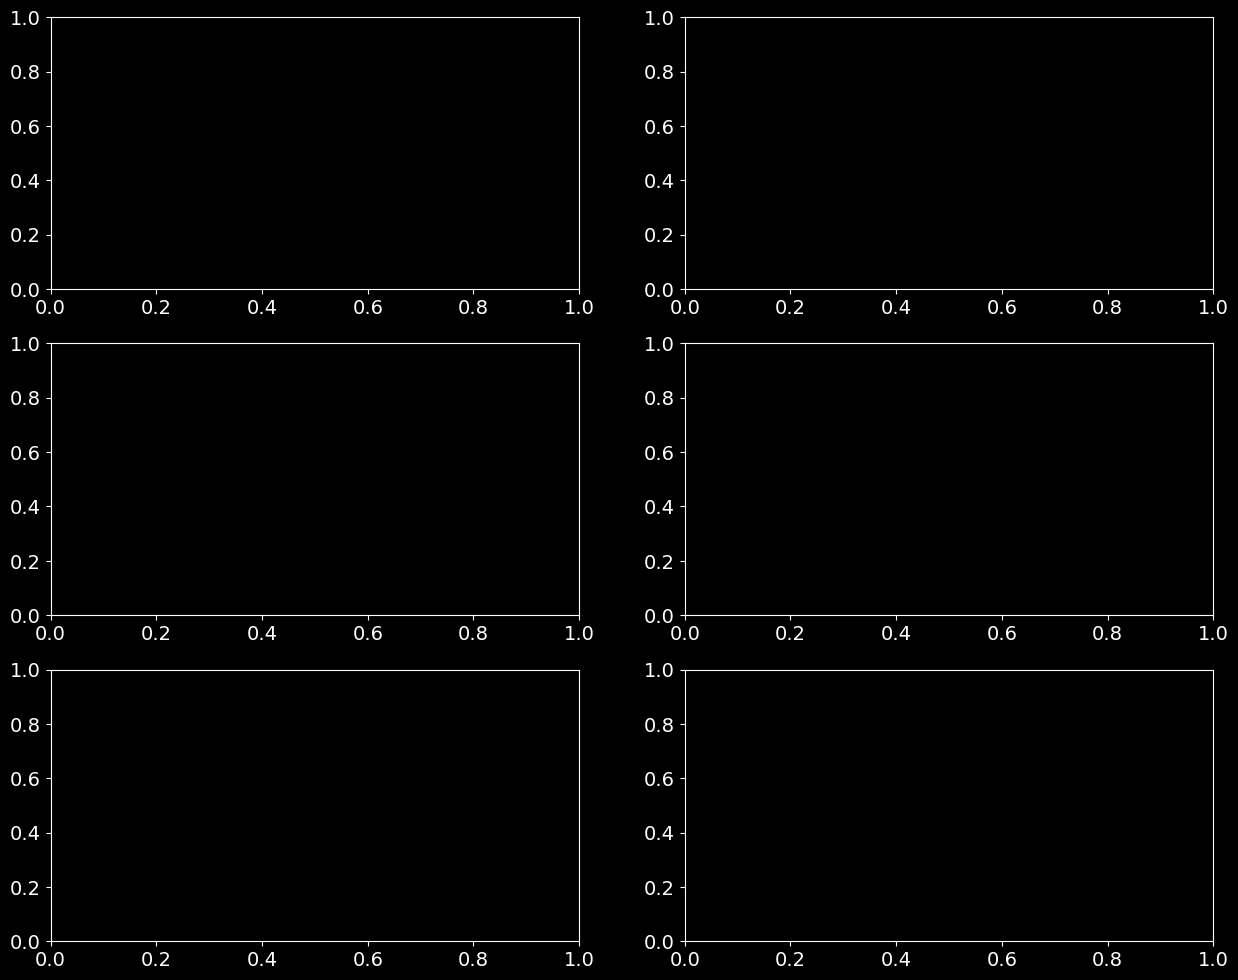

In [13]:
# Specify the folder path containing TIFF images

folder_path = r"d:\Users\Ana\Desktop\ilastik\SaveData"

# Specify experiment details
scale_pixels = 465
scale_m = 30 * 1e-3
ideal_diam = 4
fps = 10000
length = 100 #maybe find something else
angle = 45
height = 60


SD = pd.read_csv(folder_path + '\\SplashData_Cent_ST.csv',index_col = 'Ind')

StackList = SD.index  
jet_initial_velocity = []
splash_initial_velocity = []
jet_acc = []
splash_acc = []
Circularity = []
StackListLength = 1
i = 0
while i < StackListLength:
    stack = StackList[i]

    _, TopStack = cv2.imreadmulti(folder_path + '\\Top_' + stack + '.tif', [], -1 )
    # count = 6
    # for file in TopStack: file = average_stack(TopStack, count)
    line_coordinates = []
    extract_line_coord(cv2.normalize(TopStack[20], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX))
    # Step 1: Display TopStack[20]
        
    # Display the initial TopStack image
    # plt.figure()
    # plt.imshow(TopStack[20], cmap='gray')
    # plt.set_title('Impact image')
    fig, axs = plt.subplots(3, 2, figsize=(15, 12), facecolor='black') # Adjust the grid size as needed, set figure facecolor
    # Change the background color of each subplot
    for ax in axs.flat:
        ax.set_facecolor('black')
        set_axis_properties(ax)

    # Step 2: Process the images
    list_of_lists_cv2, reslice = read_tiff_images_cv2(TopStack, line_coordinates)
    reslice_jet, reslice_splash = reslice
    
    reslice_jet = np.array(reslice_jet, dtype=np.uint16)
    
    # Step 3: Cropped image
    cropped_image = crop_image_with_mouse(reslice_jet)
    img = copy.deepcopy(cropped_image)
        
    
    img = np.array(list(map(list, zip(*img)))[::-1])
    # Step 5: Derivative of Gaussian
    ks = img.shape[0]  # kernel_size
    s = 0.04  # sigma
    derivative_image_jet = convolve_with_derivative_of_gaussian(img, ks, s)
    # derivative_image_jet = convolve_with_derivative_of_gaussian(derivative_image_jet, ks, s)
    
    # Display the cropped image
    # axs[0, 1].imshow(img, cmap='gray')
    # axs[0, 1].set_title('Reslice Jet')
    
    # Step 6: Apply Sobel operator along y-axis
    sobel_image_y_jet = sobel_y(derivative_image_jet)
    
    # Display the derivative image
    # plt.imshow(derivative_image_jet, cmap='gray')
    # axs[1, 0].set_title('Convolution with a Derivative of Gaussian')
    
    # Display the Sobel y image
    # axs[1, 1].imshow(sobel_image_y, cmap='gray')
    # axs[1, 1].set_title('Sobel Y Image')
    
    # Step 7: Plot max pixel coordinates
    # rotated_filtered_image_jet = list(map(list, zip(*derivative_image_jet)))[::-1]
    rotated_filtered_image_jet = derivative_image_jet
    if ask_user_for_guidance():
        y, x = plot_max_pixel_coords_columns(rotated_filtered_image_jet, rotated_filtered_image_jet, show=0)

    else:
        y, x = plot_max_pixel_coords_row(rotated_filtered_image_jet, rotated_filtered_image_jet, show=0)

    # axs[2, 0].imshow(img)
    # axs[2, 0].plot(x, y, 'bo')
    # axs[2, 0].set_title('Max Pixel Coordinates')
    
    axs[0, 0].imshow(img, cmap = 'gray')

    axs[0, 0].plot(x, y, 'bo')
    axs[0, 0].set_title('Reslice Jet')
    axs[0, 0].set_xlabel('Time [frames]')  # Set your desired X-axis label
    axs[0, 0].set_ylabel('Distance[px]')  # Set your desired Y-axis label
    
    y = [max(y) - i for i in y]
    y = [i*scale_m/scale_pixels for i in y]
    x = [j/fps for j in x]
    # Step 8: Fit and plot second degree polynomial
    poly_function_jet, x_values_jet, y_values_jet = fit_second_degree_polynomial(x, y, "Reslice jet Second Degree Polynomial Fit")
    axs[1, 0].plot([i*1000 for i in x_values_jet], [i*1000 for i in poly_function_jet(x_values_jet)], 'r-')
    axs[1, 0].plot([i*1000 for i in x], [i*1000 for i in y], 'bo')
    axs[1, 0].set_xlabel('Time [ms]')  # Set your desired X-axis label
    axs[1, 0].set_ylabel('Distance[mm]')  # Set your desired Y-axis label
    # Adjust layout
    plt.tight_layout()

    # plt.pause(0.1)  # Force an immediate draw to display the figure
    plt.show()
    
    
# SPLASH
    reslice_splash =  np.array(reslice_splash, dtype=np.uint16)
    cropped_image = crop_image_with_mouse(reslice_splash)
    img =  copy.deepcopy(cropped_image)
    
    rotated_filtered_image_splash= np.array(list(map(list, zip(*img)))[::-1])

    ks = img.shape[0] #kernel_size
    s = 0.4 #sigma
    derivative_image_splash =convolve_with_derivative_of_gaussian(rotated_filtered_image_splash, ks, s)

    # Apply Sobel operator along y-axis
    sobel_image_y_splash = sobel_y(derivative_image_splash)

      
    y,x  = plot_max_pixel_coords_columns(derivative_image_splash, rotated_filtered_image_splash, 0)
    # x = [i*float(scale_mm/scale_pixels) for i in x]
    # y = [i*float(fps) for i in y]
    
    axs[0, 1].imshow(list(map(list, zip(*img)))[::-1], cmap = 'gray')
    axs[0, 1].plot(x, y, 'bo')
    axs[0, 1].set_title('Reslice Splash')
    axs[0, 1].set_xlabel('Time [frames]')  # Set your desired X-axis label
    axs[0, 1].set_ylabel('Distance[px]')  # Set your desired Y-axis label
    
    
    y = [max(y) - i for i in y]
    y = [i*scale_m/scale_pixels for i in y]
    x = [j/fps for j in x]
    poly_function_splash, x_values_splash, y_values_splash = fit_second_degree_polynomial(x, y, "Reslice Splash Second Degree Polynomial Fit")
    axs[1, 1].plot([i*1000 for i in x_values_splash], [i*1000 for i in poly_function_splash(x_values_splash)], 'r-')
    axs[1, 1].plot([i*1000 for i in x], [i*1000 for i in y], 'bo')
    axs[1, 1].set_xlabel('Time [ms]')  # Set your desired X-axis label
    axs[1, 1].set_ylabel('Distance[mm]')  # Set your desired Y-axis label

    
    x_values_plot, y_values_derivative_1, y_values_derivative_2, derivative_poly_function_1, derivative_poly_function_2 = plot_velocity(x_values_jet, y_values_jet, x_values_splash, y_values_splash, 0)
    axs[2, 0].plot([i*1000 for i in x_values_plot], y_values_derivative_1, color='yellow', label='Velocity Jet')
    axs[2, 0].plot([i*1000 for i in x_values_plot], y_values_derivative_2, color='green', label='Velocity Splash')
    axs[2, 0].set_xlabel('Time [ms]')  # Set your desired X-axis label
    axs[2, 0].set_ylabel('Velocity[m/s]')  # Set your desired Y-axis label
    
    
    axs[2, 0].legend()  # This line adds the legend
    acc_jet, acc_splash =  plot_acceleration(x_values_plot, derivative_poly_function_1, derivative_poly_function_2, 0)
    axs[2, 1].plot([i*1000 for i in x_values_plot], acc_jet, color='yellow', label='Acceleration Jet')
    axs[2, 1].plot([i*1000 for i in x_values_plot], acc_splash, color='green', label='Acceleration Splash')
    axs[2, 1].set_xlabel('Time [ms]')  # Set your desired X-axis label
    axs[2, 1].set_ylabel('Acceleration[m/s^2]')  # Set your desired Y-axis label
    axs[2, 1].legend()  # This line adds the legend
    
    jet_initial_velocity.append(y_values_derivative_1[0])
    splash_initial_velocity.append(y_values_derivative_2[0])
    jet_acc.append(acc_jet[0])
    splash_acc.append(acc_splash[0])
    
    plt.pause(0.1)  # Force an immediate draw to display the figure
    plt.show()
    
    SD.loc[stack, 'angle[degrees]'] = angle
    SD.loc[stack, 'IdealDiam[mm]'] = ideal_diam
    SD.loc[stack, 'Height[cm]'] = height
    SD.loc[stack,'Top Velocity jet [m/s]'] = y_values_derivative_1[0]
    SD.loc[stack,'Top Velocity splash [m/s]'] = y_values_derivative_2[0]
    SD.loc[stack,'Acc splash [m/s^2]'] = acc_splash[0]
    SD.loc[stack,'Acc jet [m/s^2]'] =acc_jet[0]
    
    if ask_user_for_approval():
        print(f"Stack {i} approved.")
        i += 1  # Move to the next image
    else:
        print(f"Redoing process for stack {i}.")
        plt.close(fig)

# SD.to_csv(folder_path + '\\SplashData_Cent_ST.csv',index_label = 'Ind')